In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import re
import os
import json
import cv2 as cv
import numpy as np
from glob import glob
from copy import deepcopy
from google.colab.patches import cv2_imshow as imshow

# Visualization

In [32]:
class Visualization():
  def __init__(self, metadata_dir, image_dir) -> None:
    self.metadata_fp_list = glob(f'{metadata_dir}/*.json')
    self.image_fp_list = glob(f'{image_dir}/*.jpg') + glob(f'{image_dir}/*.jpeg')
    self.n = len(self.metadata_fp_list)

    if self.n != len(self.image_fp_list):
      raise AssertionError("different number of metadata and image files")

    self.metadata_dir = metadata_dir
    self.image_dir = image_dir


  def get_input_params(self, fp):
    with open(fp, 'r') as f:
      data = json.load(f)

    ip_params = {
        'coords': [],
        'x_min': [],
        'y_min': [],
        'x_max': [],
        'y_max': [],
        'label': []
    }
    for d in data:
      if d['type'] != 'polygonlabels':
        continue

      width = d['original_width']
      height = d['original_height']

      coords = np.array(d['value']['points'], np.int32)
      coords[:, 0]  = coords[:, 0]*width/100
      coords[:, 1]  = coords[:, 1]*height/100

      x_max, x_min = coords[:, 0].max(), coords[:, 0].min()
      y_max, y_min = coords[:, 1].max(), coords[:, 1].min()

      # (1 x N x 2)
      coords = coords.reshape((1, -1, 2))

      label = f"{', '.join(d['value']['polygonlabels'])}"

      ip_params['coords'].append(coords)
      ip_params['x_min'].append(x_min)
      ip_params['y_min'].append(y_min)
      ip_params['x_max'].append(x_max)
      ip_params['y_max'].append(y_max)
      ip_params['label'].append(label)

    return ip_params

  def generate_polygon_and_bbox(self, param, fp):
    image = cv.imread(fp)
    org_image = deepcopy(image)

    for i, coords in enumerate(param['coords']):
      x_min = param['x_min'][i]
      y_min = param['y_min'][i]
      x_max = param['x_max'][i]
      y_max = param['y_max'][i]
      label = param['label'][i]

      color=tuple(np.random.randint(0, 256, size=3).tolist())
      cv.polylines(img=image, pts=coords, isClosed=True, color=color, thickness=1)
      cv.fillConvexPoly(img=image, points=coords, color=color)
      image = cv.addWeighted(src1=org_image, alpha=0.1, src2=image, beta=0.9, gamma=0)
      cv.rectangle(img=image, pt1=(x_min-10, y_min-10), pt2=(x_max+10, y_max+10), color=color, thickness=1)

      bbox_size = len(label)*5
      cv.rectangle(img=image, pt1=(x_min-10, y_min-10), pt2=(x_min+bbox_size, y_min), color=(0, 0, 0), thickness=-1)
      cv.putText(img=image, text=label, org=(x_min-10, y_min-3), fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=(255, 255, 255), thickness=1)

    return image

  def visualize(self, k=5, op_path=None):
    k = min(k, self.n)
    for i in range(k):
      image_fp = self.image_fp_list[i]
      fname = image_fp[image_fp.rfind('/')+1:]
      fname = re.sub('.jpg|.jpeg', '', fname)

      metadata_fp = f'{self.metadata_dir}/{fname}.json'
      ip_params = self.get_input_params(metadata_fp)

      image = self.generate_polygon_and_bbox(ip_params, image_fp)
      imshow(image)

      if op_path:
        cv.imwrite(f'{op_path}/{fname}_visualization.png', image)
        print("image saved in output path")

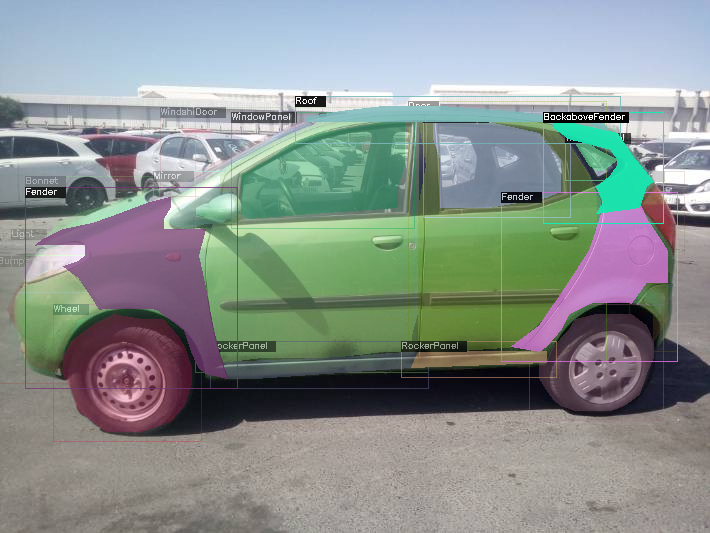

image saved in output path


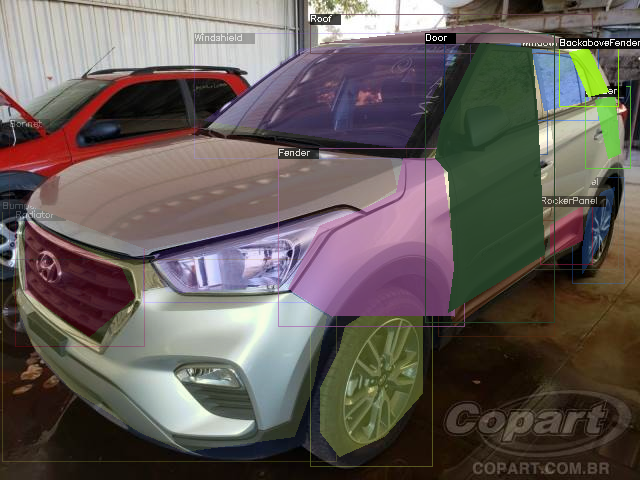

image saved in output path


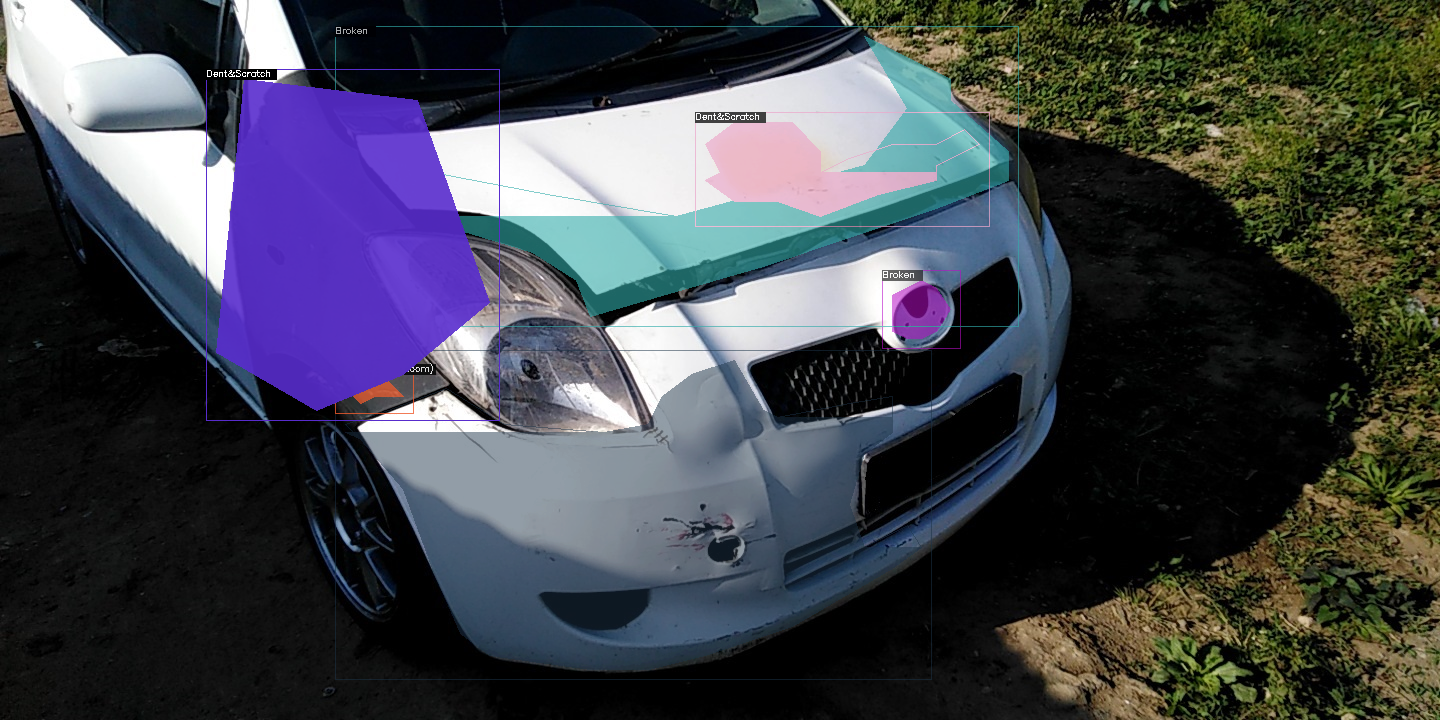

image saved in output path


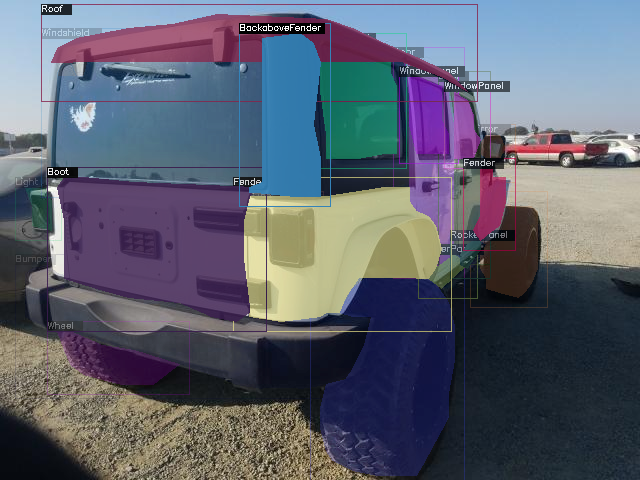

image saved in output path


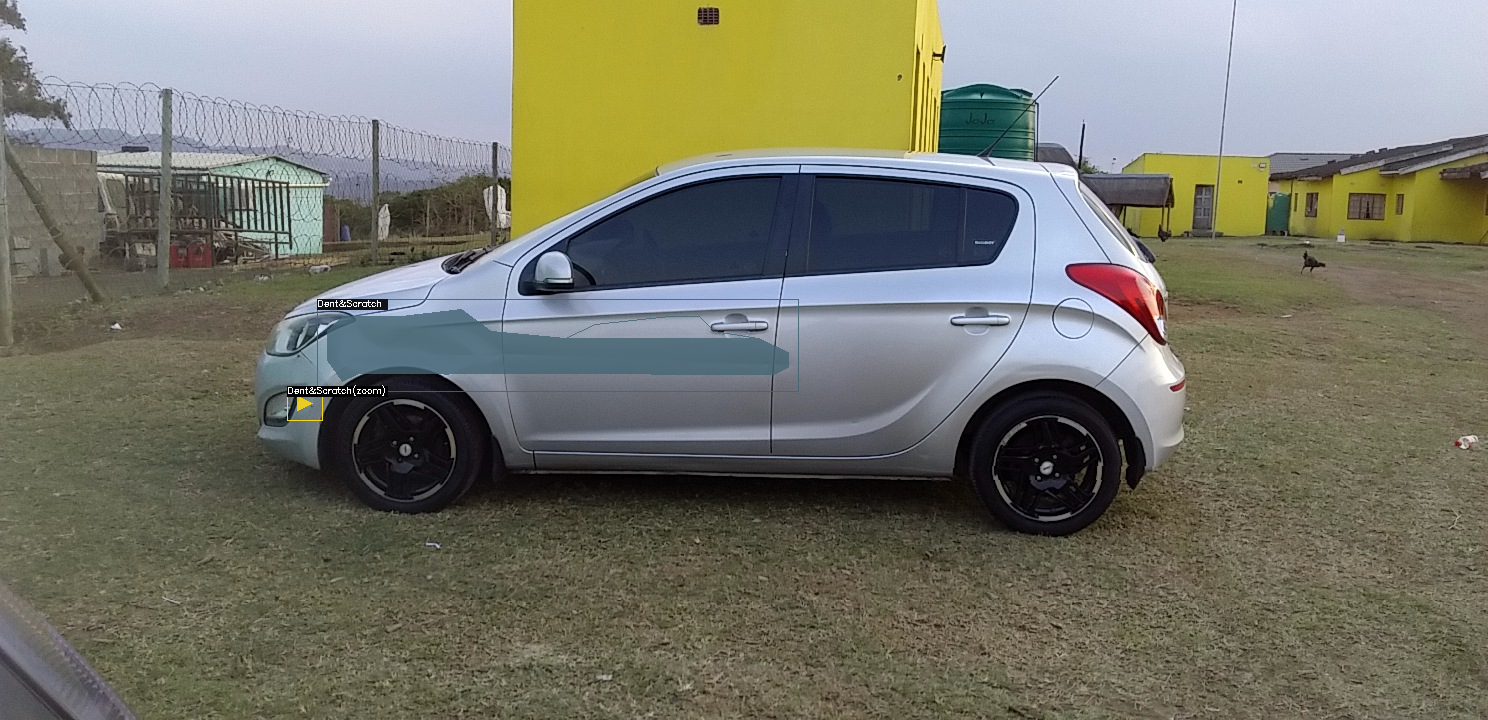

image saved in output path


In [34]:
data_dir = '/gdrive/My Drive/car_damage_detection/visualization/visualization_data'

metadata_dir = f'{data_dir}/metadata'
image_dir = f'{data_dir}/images'

op_path = '/gdrive/My Drive/car_damage_detection/visualization/output'

visual = Visualization(metadata_dir, image_dir)
visual.visualize(k = 5, op_path = op_path)

# Classification


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image_dataset_from_directory, image

In [3]:
import sys
sys.path.insert(0, '/gdrive/My Drive/car_damage_detection/scripts/')

from model_architectures import ModelArchitectures

In [11]:
class Classification():
  def __init__(self, train_data_dir, val_data_dir):
    self.train_data_dir = train_data_dir
    self.val_data_dir = val_data_dir

    self.total_models = 1
    self.img_size = (224, 224)
    self.batch_size = 32

  def prepare_train_val_dataset(self):

    # 1. Load Dataset
    train_ds = image_dataset_from_directory(
        self.train_data_dir,
        seed=123,
        image_size=self.img_size,
        batch_size=self.batch_size
    )

    val_ds = image_dataset_from_directory(
        self.val_data_dir,
        seed=123,
        image_size=self.img_size,
        batch_size=self.batch_size
    )

    self.class_names = train_ds.class_names
    print(f'Class Names ---> {self.class_names}')

    # 2. cache + prefetch + shuffle
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds

  def get_model_archs(self):
    archs = ModelArchitectures(self.class_names)
    model_archs = []
    model_archs.append(archs.model_2())
    return model_archs

  def train_models(self, model_archs, train_ds, val_ds):

    trained_models = []
    model_history = []
    for i, model in enumerate(model_archs):
      history = model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=5
      )
      model_history.append(history)
      print(f'history for model {i+1} ---> \n{history}')

      trained_models.append(model)
      return trained_models, model_history

  def evaluate_models(self, models):

    for i, model in enumerate(models):
      print(f'Evaluation for model {i+1} ---> \n')
      loss, acc = model.evaluate(val_ds)
      print(f"Validation Accuracy: {acc} \n")
      print(f"Validation Loss: {loss} \n")

  def save_models(self, models, op_path):
    for i, model in enumerate(models):
      model.save(f'{op_path}/model_{i+1}.keras')

    print("All the models saved successfully!")

  def predict(self, models, img_path):

    img = image.load_img(img_path, target_size=self.img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Batch dimension

    # Predict
    for i, model in enumerate(models):
      pred = model.predict(img_array)
      predicted_class = self.class_names[np.argmax(pred[0])]
      print(f"Predicted class by model {i+1}: {predicted_class}")


In [12]:
train_data_dir = '/gdrive/My Drive/car_damage_detection/classification/training'
val_data_dir = '/gdrive/My Drive/car_damage_detection/classification/validation'

classif = Classification(train_data_dir, val_data_dir)
train_ds, val_ds = classif.prepare_train_val_dataset()
model_archs = classif.get_model_archs()
print(models[0].summary())
models, model_history = classif.train_models(model_archs, train_ds, val_ds)

Found 1840 files belonging to 2 classes.
Found 460 files belonging to 2 classes.
Class Names ---> ['00-damage', '01-whole']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,431,880 (28.35 MB)

 Trainable params: 131,458 (513.51 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 262,918 (1.00 MB)

None
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 558s 9s/step - accuracy: 0.6564 - loss: 0.6947 - val_accuracy: 0.8370 - val_loss: 0.3590
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 467s 8s/step - accuracy: 0.8203 - loss: 0.4188 - val_accuracy: 0.8609 - val_loss: 0.3197
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 443s 8s/step - accuracy: 0.8529 - loss: 0.3289 - val_accuracy: 0.9152 - val_loss: 0.2370
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 503s 9s/step - accuracy: 0.8697 - loss: 0.3046 - val_accuracy: 0.9196 - val_loss: 0.2252
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 503s 8s/step - accuracy: 0.8772 - loss: 0.2825 - val_accuracy: 0.9022 - val_loss: 0.2200
history for model 1 ---> 


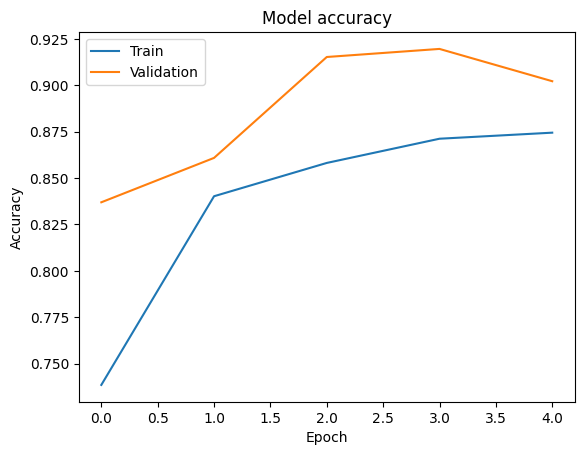

In [13]:
import matplotlib.pyplot as plt

history = model_history[0]
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# classif.evaluate_models(models)
classif.save_models(models, '/gdrive/My Drive/car_damage_detection/classification/saved_models')

All the models saved successfully!
